# Style transfer

In [3]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [ ]:
# Set image width and height
width = 512
height = 512

# Load content image

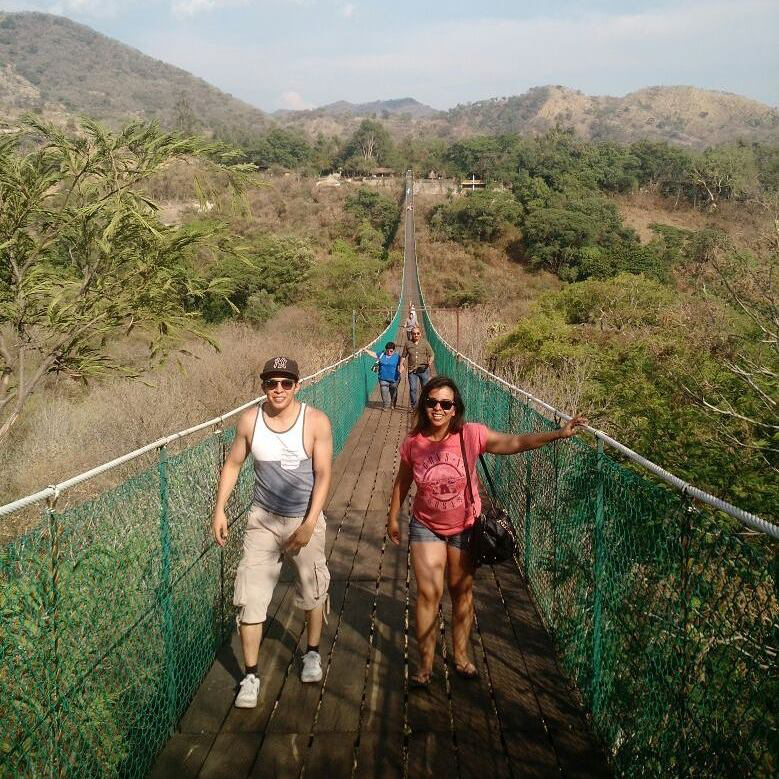

In [4]:
path = 'images/me1.jpg'
content_image = Image.open(path)
content_image = conte_